In [1]:
import numpy as np
import pandas as pd
import lostruct as ls
from skbio.stats.ordination import pcoa
import plotly.express as px
import plotly.graph_objects as go
import phate
from collections import Counter
import phate
import umap
import statistics as stats
#import hdbscan
import phate
from sklearn.decomposition import PCA

In [2]:
vcf_file = "founders_filtered.bcf"
landmarks = ls.get_landmarks(vcf_file)
samples = ls.get_samples(vcf_file)

In [7]:
results = list()
snp_positions = list()
snps = list()

for landmark in landmarks:
    windows, positions = ls.parse_vcf(vcf_file, landmark, 450)
    for i, window in enumerate(windows):
        snps.append(window)
        results.append(ls.eigen_windows(window, 10, 1))
        snp_positions.append([landmark, positions[i]])

In [8]:
len(snp_positions)

3062

In [9]:
#results

In [10]:
# Parse VCF to get windows and positions of each SNP within each window
#windows, positions = ls.parse_vcf(vcf_file, "S3", 250)
# ls.Window.SNP specifies window sizes are by SNP count. ls.Window.BP specifies windows are in base pair lengths.

# *** ls.Window.BP is not yet implemented, however. ***
# Please see: https://github.com/jguhlin/lostruct-py/issues/8

# Accumulate output of eigen_windows
#result = list()
#for x in windows:
#    result.append(ls.eigen_windows(x, 2, 1))

In [11]:
# Convert to numpy array
result = np.vstack(results)

/home/josephguhlin/miniconda3/envs/keras/lib/python3.8/site-packages/numpy/core/shape_base.py:121: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  ary = asanyarray(ary)


In [12]:
# Get PCA distances comparison matrix
# pc_dists = ls.get_pc_dists(result)

In [ ]:
# An additional mode, fastmath, is available. Trading some accuracy for a slight speed boost (~8%)
pc_dists = ls.get_pc_dists(result, fastmath=True)

/home/josephguhlin/miniconda3/envs/keras/lib/python3.8/site-packages/lostruct/lostruct.py:164: NumbaWarning: The TBB threading layer requires TBB version 2019.5 or later i.e., TBB_INTERFACE_VERSION >= 11005. Found TBB_INTERFACE_VERSION = 10003. The TBB threading layer is disabled.
  comparison[i,j] = dist_sq_from_pcs_fastmath(vals[i], vals[j], eigenvecs[i], eigenvecs[j])


In [ ]:
#pc_dists = np.load("pc_dists.npy")
np.save("localpca_founders.npy", pc_dists)
np.save("localpca_founders_positions.npy", snp_positions)
np.save("localpca_founders_results.npy", result)

#result = np.load("localpca_founders_results.npy", allow_pickle=True)
#pc_dists = np.load("localpca_founders.npy", allow_pickle=True)
#snp_positions = np.load("localpca_founders_positions.npy", allow_pickle=True)
results = result

In [8]:
# Get PCoA value of pc_dists matrix (this is equivalent to R's MDS)
# PLEASE NOTE: See section below: Working with Large Datasets
# For recommended ways to run pcoa

mds = pcoa(pc_dists)

In [73]:
mean = np.mean(mds.samples["PC1"])
sd = np.std(mds.samples["PC1"])

previous_pos = 0
highlights = list()
current_chr = "S1"
current_start = 0
current_end = 0

for pos in np.where(np.abs(mds.samples["PC1"]) >= mean + 2 * sd)[0]:
    if pos == previous_pos + 1:
        current_end = snp_positions[pos][1][-1]
    else:
        #print("Previous: {} cur: {}".format(previous_pos, pos))

        if previous_pos != 0:
            highlights.append((current_chr, current_start, current_end))
        
        current_chr   = snp_positions[pos][0]
        current_start = snp_positions[pos][1][0]
        current_end   = snp_positions[pos][1][-1]
        previous_pos = pos

with open("mds1.highlight", 'w') as writer:
    for x in highlights:
        writer.write("\t".join(map(str, x)))
        writer.write("\n")

In [74]:
mean = np.mean(mds.samples["PC2"])
sd = np.std(mds.samples["PC2"])

previous_pos = 0
highlights = list()
current_chr = "S1"
current_start = 0
current_end = 0

for pos in np.where(np.abs(mds.samples["PC2"]) >= mean + 2 * sd)[0]:
    if pos == previous_pos + 1:
        current_end = snp_positions[pos][1][-1]
    else:
        #print("Previous: {} cur: {}".format(previous_pos, pos))

        if previous_pos != 0:
            highlights.append((current_chr, current_start, current_end))
        
        current_chr   = snp_positions[pos][0]
        current_start = snp_positions[pos][1][0]
        current_end   = snp_positions[pos][1][-1]
        previous_pos = pos

with open("mds2.highlight", 'w') as writer:
    for x in highlights:
        writer.write("\t".join(map(str, x)))
        writer.write("\n")

In [9]:
from itertools import cycle

In [12]:
kakapo_colors = ["#7D9D33", "#CED38C", "#DCC949", "#BCA888", "#CD8862", "#775B24"]
chrs = [i[0] for i in snp_positions]
colorfn = cycle(["#7D9D33", "#DCC949", "#BCA888", "#CD8862", "#775B24"])
colors = [next(colorfn) for _ in chrs]

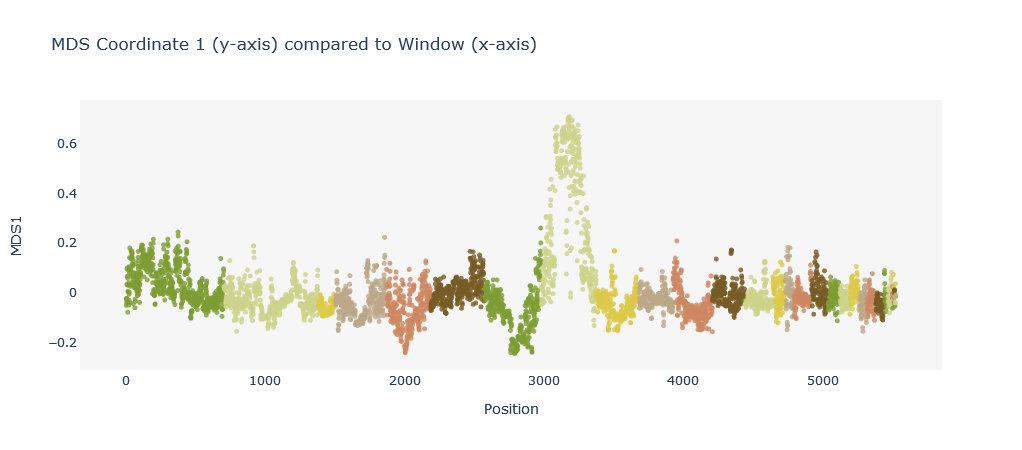

In [15]:
fig = px.scatter(y=mds.samples["PC1"], 
                 title="MDS Coordinate 1 (y-axis) compared to Window (x-axis)", 
                 color=chrs, 
                 labels=chrs,
                 color_discrete_sequence=kakapo_colors)

fig.update_traces(marker=dict(size=5, opacity=0.8))
fig.update_layout(showlegend=False)
fig.update_layout(xaxis=dict(showgrid=False, zeroline=False, showline=True, title="Position"))
fig.update_layout(yaxis=dict(showgrid=False, zeroline=False, showline=True, title="MDS1"))
fig.update_layout(paper_bgcolor="white")
fig.update_layout(plot_bgcolor="#f6f6f6")
fig.write_image("mds_coord1.svg")
fig

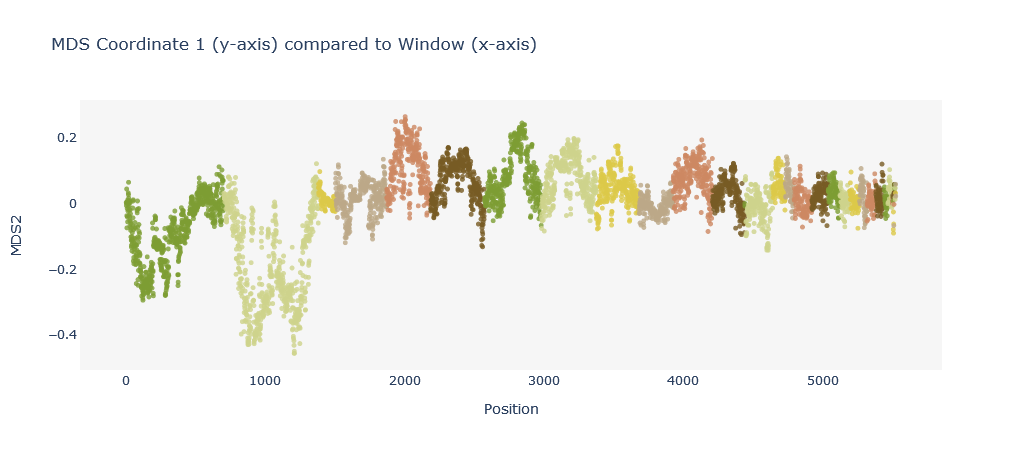

In [31]:
#px.scatter(y=mds.samples["PC2"], title="MDS Coordinate 2 (y-axis) compared to Window (x-axis)")
fig = px.scatter(y=mds.samples["PC2"], 
                 title="MDS Coordinate 1 (y-axis) compared to Window (x-axis)", 
                 color=chrs, 
                 labels=chrs,
                 color_discrete_sequence=kakapo_colors)

fig.update_traces(marker=dict(size=5, opacity=0.8))
fig.update_layout(showlegend=False)
fig.update_layout(xaxis=dict(showgrid=False, zeroline=False, showline=True, title="Position"))
fig.update_layout(yaxis=dict(showgrid=False, zeroline=False, showline=True, title="MDS2"))
fig.update_layout(paper_bgcolor="white")
fig.update_layout(plot_bgcolor="#f6f6f6")
fig.write_image("mds_coord2.svg")
fig

In [10]:
#for j in snp_positions:
#    print(j[1])

In [15]:
snp_positions[1][1][125]

446821

In [49]:
mds.samples["PC1"]

0      -0.050553
1      -0.026915
2      -0.022068
3      -0.038682
4      -0.024059
          ...   
5522   -0.041175
5523   -0.038456
5524    0.036429
5525   -0.015416
5526   -0.008751
Name: PC1, Length: 5527, dtype: float64

In [37]:
with open("pc2.scatter", 'w') as writer:
    for i,_ in enumerate(snp_positions):
        output_line = list()
        output_line.append(snp_positions[i][0])
        output_line.append(snp_positions[i][1][0])
        output_line.append(snp_positions[i][1][-1])
        output_line.append(mds.samples["PC2"][i])
        writer.write("\t".join(map(str, output_line)))
        writer.write("\n")

In [74]:
result.shape

(5527, 4)

In [39]:
[mds.samples["PC2"].min(), mds.samples["PC2"].max()]

[-0.4552232821775574, 0.26443053754437473]

In [48]:
[np.mean(mds.samples["PC1"]), np.std(mds.samples["PC1"])]

[1.4784225549558805e-16, 0.12636207877289127]

In [295]:
np.argmin(np.abs(mds.samples["PC1"]) + np.abs(mds.samples["PC2"]))

4784

# Getting the colors rights

In [17]:
kakapo_colors = ["#7D9D33", "#CED38C", "#DCC949", "#BCA888", "#CD8862", "#775B24"]

# Local PCA Windows, zoom in

In [18]:
colors = [x == "Richard_Henry" for x in samples]

In [19]:
results[80][3].T.shape

(43, 10)

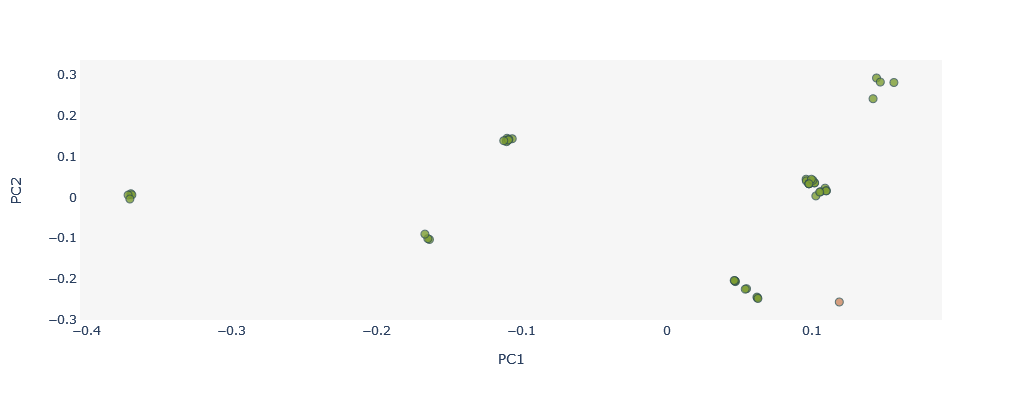

In [34]:
fig = px.scatter(x=results[875][3][0], 
                 y=results[875][3][1], 
                 color=colors, 
                 color_discrete_sequence=["#7D9D33", "#CD8862"],
                 width=500, height=400)

fig.update_traces(marker=dict(size=8, opacity=0.8, line=dict(width=1, color='DarkSlateGray')))
fig.update_layout(showlegend=False)
fig.update_layout(xaxis=dict(showgrid=False, zeroline=False, showline=True, title="PC1"))
fig.update_layout(yaxis=dict(showgrid=False, zeroline=False, showline=True, title="PC2"))
fig.update_layout(paper_bgcolor="white")
fig.update_layout(plot_bgcolor="#f6f6f6")
fig.write_image("window_875.svg")
fig


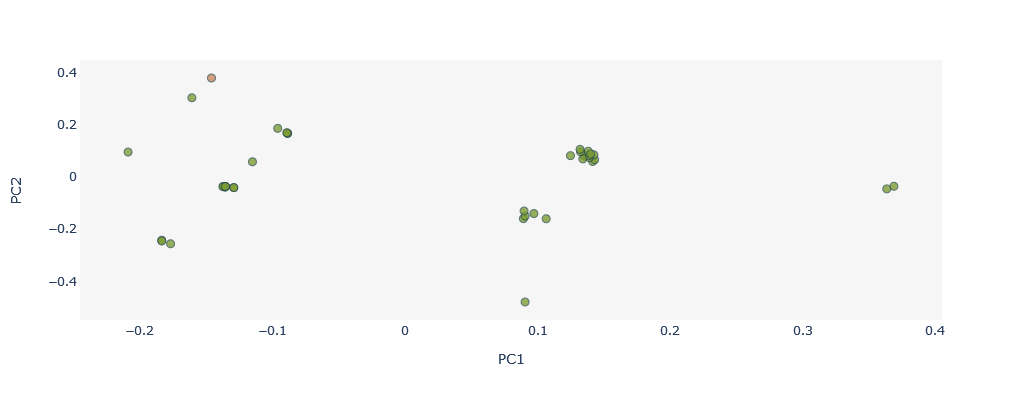

In [35]:
fig = px.scatter(x=results[3173][3][0], 
                 y=results[3173][3][1], 
                 color=colors, 
                 color_discrete_sequence=["#7D9D33", "#CD8862"],
                 width=500, height=400)

fig.update_traces(marker=dict(size=8, opacity=0.8, line=dict(width=1, color='DarkSlateGray')))
fig.update_layout(showlegend=False)
fig.update_layout(xaxis=dict(showgrid=False, zeroline=False, showline=True, title="PC1"))
fig.update_layout(yaxis=dict(showgrid=False, zeroline=False, showline=True, title="PC2"))
fig.update_layout(paper_bgcolor="white")
fig.update_layout(plot_bgcolor="#f6f6f6")
fig.write_image("window_3173.svg")
fig


In [21]:
results[80][3][1].shape

(43,)

## Global Mean PCA

In [4]:
snps_new = list()
for j in snps:
    snps_new.append(j.todense())

snps = np.asarray(snps_new)


NameError: name 'snps' is not defined

In [5]:
snps.shape

NameError: name 'snps' is not defined

In [6]:
snps = np.reshape(snps, (5527*250, 43))
snps.shape

NameError: name 'snps' is not defined

In [7]:
snps_nomissing = snps[~np.isnan(snps).any(axis=1), :]
snps_nomissing.shape

NameError: name 'snps' is not defined

In [79]:
from sklearn.preprocessing import StandardScaler

pca = PCA(2)
pcs = pca.fit_transform(StandardScaler().fit_transform(snps_nomissing.T))

In [80]:
pcs.shape

(43, 2)

In [81]:
pcs = StandardScaler().fit_transform(pcs)

In [3]:
# Plot for Supplemental

fig = px.scatter(x=pcs[:, 0], y=pcs[:, 1], color=colors,
                 color_discrete_sequence=["#7D9D33", "#CD8862"],
                 width=500, height=400)

fig.update_traces(marker=dict(size=8, opacity=0.8, line=dict(width=1, color='DarkSlateGray')))
fig.update_layout(showlegend=False)
fig.update_layout(xaxis=dict(showgrid=False, zeroline=False, showline=True, title="PC1"))
fig.update_layout(yaxis=dict(showgrid=False, zeroline=False, showline=True, title="PC2"))
fig.update_layout(paper_bgcolor="white")
fig.update_layout(plot_bgcolor="#f6f6f6")
fig.write_image("mean_pca.svg")
fig

NameError: name 'pcs' is not defined

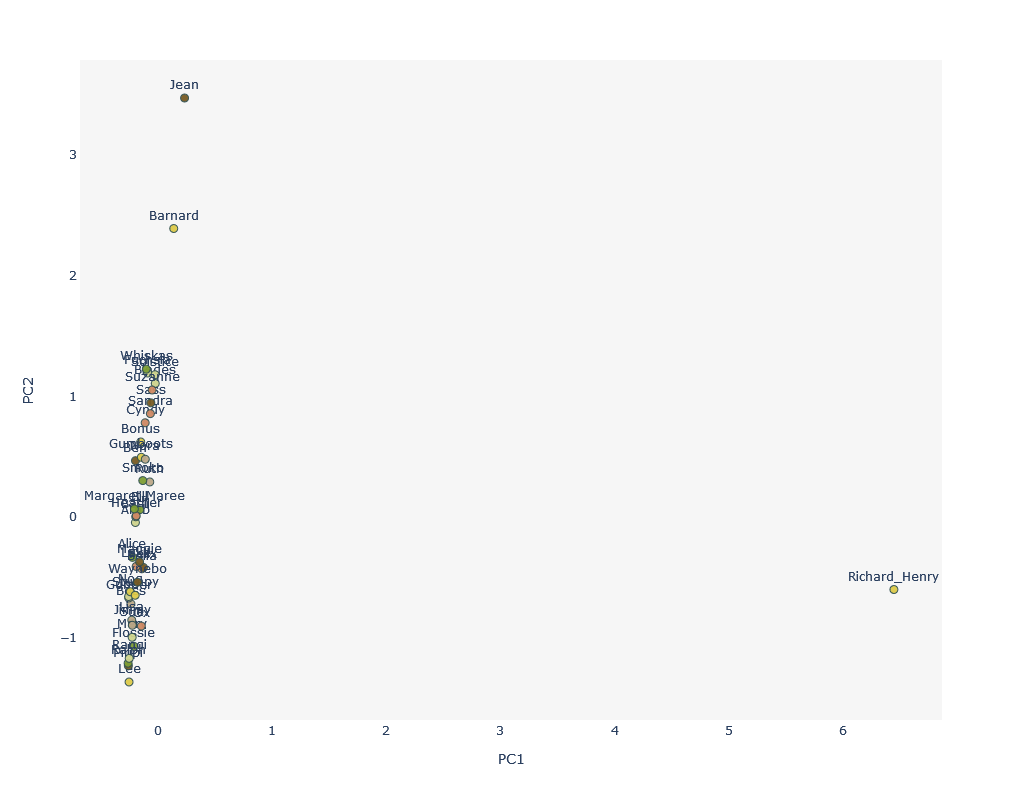

In [96]:
# Larger founder relatedness plot

fig = px.scatter(x=pcs[:, 0], y=pcs[:, 1], color=samples,
                 labels=samples, text=samples,
                 color_discrete_sequence=kakapo_colors,
                 width=800, height=800)

fig.update_traces(marker=dict(size=8, opacity=0.95, line=dict(width=1, color='DarkSlateGray')))
fig.update_layout(showlegend=False)
fig.update_layout(xaxis=dict(showgrid=False, zeroline=False, showline=True, title="PC1"))
fig.update_layout(yaxis=dict(showgrid=False, zeroline=False, showline=True, title="PC2"))
fig.update_layout(paper_bgcolor="white")
fig.update_layout(plot_bgcolor="#f6f6f6")
fig.write_image("mean_pca.svg")
fig.update_traces(textposition='top center')
fig.write_image("founders_relatedness_large.svg")

fig

In [30]:
pca.explained_variance_ratio_

array([0.21809715, 0.07840751])

# From previous calc

In [108]:
pcs = list()
for result in results:
    print(result[3].T.shape)
    break
    pcs.append(result[3].T)

    #for x in result[3].T:
    #    print(x.shape)
    #    pcs.append(x)
    #    print(x)
    #    break

(43, 10)


In [107]:
np.asarray(pcs).shape

(5527, 43, 10)

In [104]:
pcs = np.mean(pcs, axis=1)
pcs.shape

(43, 10)

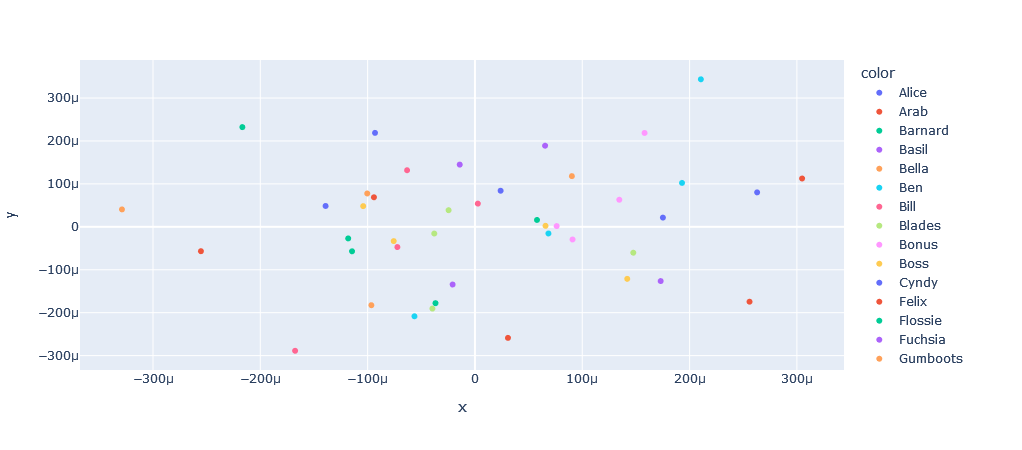

In [105]:
px.scatter(x=pcs[:, 0], y=pcs[:, 1], color=samples)

In [242]:
plink2 = pd.read_csv("plink2.eigenvec", sep="\t")
plink2

,#IID,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10
0,Adelaide,0.206707,-0.008444,-0.023067,-0.010730,-0.074267,0.079921,-0.239378,0.164124,-0.184797,-0.036443
1,Al,-0.024572,-0.054252,0.035171,-0.055832,0.057071,-0.028582,-0.044667,0.004567,-0.007393,0.022168
2,Alice,-0.023861,-0.042174,-0.000864,0.040135,0.123360,0.015736,-0.065396,-0.050525,0.065055,-0.023805
3,Aparima,-0.022589,-0.040333,0.000232,-0.162433,-0.046453,-0.068463,-0.050347,-0.046390,-0.061298,0.004947
4,Arab,-0.021014,0.006959,0.063184,-0.001303,0.142783,0.048478,-0.041853,-0.016935,0.016053,0.035803
...,...,...,...,...,...,...,...,...,...,...,...
164,Whiskas,-0.012283,0.042587,0.162317,0.105080,0.006788,-0.111362,-0.071470,-0.125953,-0.222906,0.026014
165,Wiremu,-0.005314,-0.029176,0.129990,0.107423,-0.044951,-0.039544,-0.068304,0.050040,-0.037652,-0.056906
166,Wolf,-0.014788,-0.008322,-0.148188,0.087755,-0.010043,-0.061555,0.012235,0.138602,-0.026028,0.039541
167,Yasmine,-0.010621,-0.036505,0.040163,0.031329,-0.086074,0.108406,0.012493,0.029112,0.079002,-0.150378


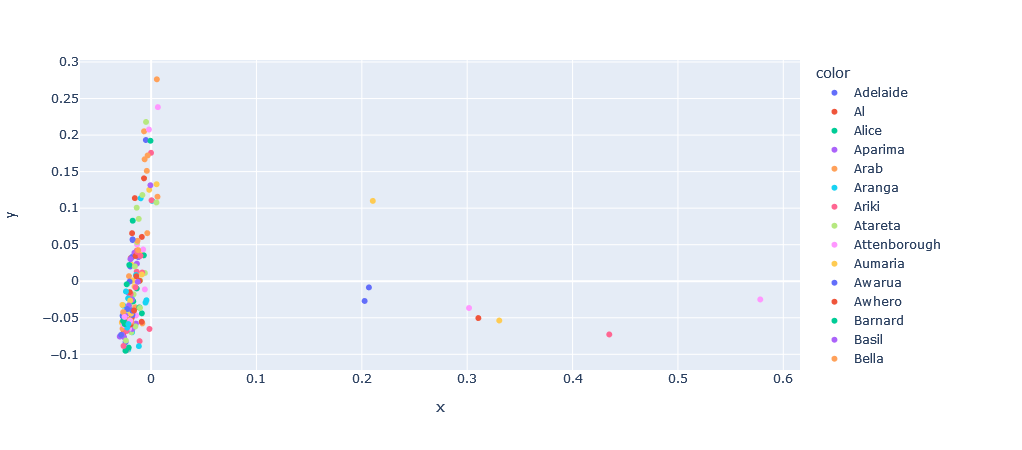

In [243]:
px.scatter(x=plink2["PC1"], y=plink2["PC2"], color=plink2["#IID"])

In [ ]:
px.scatter(y=mds.samples["PC1"], title="MDS Coordinate 1 (y-axis) compared to Window (x-axis)")

In [ ]:
def get_furthest_individuals(results):
    furthest = list()
    for n,result in enumerate(results):
        d = dict()
        vals = list()
        for i,x in enumerate(result[3].T):
            centroid = np.mean(result[0][3].T, axis=0)
            dist = np.linalg.norm(x-centroid)
            d[dist] = i
            vals.append(dist)
        vals = sorted(vals)
        vals.reverse()
        furthest.append((n, samples[d[vals[0]]]))
        #tops = [samples[d[x]] for x in vals[0]]
        #tops.sort()
        
        #furthest.append(tuple(tops))
    return furthest

get_furthest_individuals(result)

In [ ]:
bychr_pop = list()

for n in range(len(result)):
    toplot = result[n][3]
    
    reducer = umap.UMAP()
    embedding = reducer.fit_transform(toplot.T)
    
    clusterer = hdbscan.HDBSCAN(min_cluster_size=3, cluster_selection_epsilon=0.5)
    clusterer.fit(embedding)
    
    d = dict()
    
    for i in clusterer.labels_:
        if i in d:
            d[i] += 1
        else:
            d[i] = 1
    
    bychr_pop.append(d)

In [ ]:
groups = dict()
plot_data = list()

z = list(bychr_pop[0].keys())
z.sort()
z

for n in bychr_pop:
    for i in range(-1, 7):
        if i not in groups:
            groups[i] = list()
        if i not in n:
            groups[i].append(0)
        else:
            groups[i].append(n[i])
        #plot_data.append(bychr_pop[0][i])


In [ ]:
groups.keys()

In [ ]:
import plotly.graph_objects as go
fig = go.Figure()
fig.add_trace(go.Bar(x=list(range(len(groups[0]))), y=groups[-1]))
fig.add_trace(go.Bar(x=list(range(len(groups[0]))), y=groups[0]))
fig.add_trace(go.Bar(x=list(range(len(groups[0]))), y=groups[1]))
fig.add_trace(go.Bar(x=list(range(len(groups[0]))), y=groups[2]))
fig.add_trace(go.Bar(x=list(range(len(groups[0]))), y=groups[3]))
fig.add_trace(go.Bar(x=list(range(len(groups[0]))), y=groups[4]))
fig.add_trace(go.Bar(x=list(range(len(groups[0]))), y=groups[5]))
fig.add_trace(go.Bar(x=list(range(len(groups[0]))), y=groups[6]))

fig.update_layout(barmode='stack')


In [ ]:
px.scatter(x=embedding[:,0], y=embedding[:,1], color=samples)

In [ ]:
[positions[pc_loc][0], positions[pc_loc][-1]]

In [ ]:
clusterer = hdbscan.HDBSCAN(min_cluster_size=3, cluster_selection_epsilon=0.5)
clusterer.fit(embedding)

In [ ]:
clusterer.labels_

In [ ]:
px.scatter(x=embedding[:,0], y=embedding[:,1], color=clusterer.labels_)

In [ ]:
fig = go.Figure(data=go.Scattergl(
    y = mds_windows['PC1'],
))
fig.show()

In [ ]:
mds_windows

In [ ]:
pc_dists = np.load("pc_dists.npy")

In [ ]:
pc_dists[0]